# A causal approach to handling missing data
## Outline
### 1. Understanding the Impact of Missing Data
* Nature of Missing Data: Define MCAR, MAR, MNAR
* Challenges: How do different types of missing data affect the validity and generalizability of study conclusions
### 2. Implications of Missing Data in causal analysis:
* Bias from missing Data: Example illustrations if how missing dietary data could skew results
### 3. Imputation Techniques and Causal Structure:
* Comparison of Techniques: Comparison of traditional imputation techniques with causal imputation methods, highlighting the advantages of the latter maintaining the itegrity of causal inferences
### 4. Causal Approach to handle missing data:
* Application of DAGs
* Methodology: Multiple imputation with DAGs to handle missing values appropriately
### 5. Justification and Importance of the causal approach
* Avantages: reducing bias, preserving relationshipd
* Limitations

## Sources
1. Causal inference - A missing data perspeective - [Read the paper here](https://projecteuclid.org/journals/statistical-science/volume-33/issue-2/Causal-Inference-A-Missing-Data-Perspective/10.1214/18-STS645.pdf)
2. Missing Data as a causal inference problem - https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2343794
3. Missing data and multiple imputation in clinical epidemiological research - https://www.tandfonline.com/doi/pdf/10.2147/clep.s129785
4. Handling of missing data with multiple imputation in observational studies that address causal questions: protocol for a scoping review - https://bmjopen.bmj.com/content/13/2/e065576.abstract


## Example
### Scenario
We have an observational dataset with missing data, and we would like to figure out how adherence to a diet reflects in weight loss.
### Variables
* Diet Adherence (continous)
* Weight Loss (continous)
* Initial Weight (continous)
* Age (continous)
### Steps
1. Generate Datsets for MCAR, MAR and MNAR
2. Simple Analysis without handling missing data
3. Simple Imputation
4. Multiple Imputation using DAGs (statsmodels and networkx)

In [486]:
# Imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

from sklearn.impute import IterativeImputer, SimpleImputer
from semopy import Model, Optimizer
from statsmodels.formula.api import ols
from statsmodels.imputation import mice

In [467]:
# Data Generation
np.random.seed(73)
data_size = 100
data = pd.DataFrame({
    'initial_weight': np.random.normal(70, 15, data_size), # mean weight of 70kg with a std of 15kg
    'age': np.random.randint(18, 65, data_size), # Age from 18 to 65
})

# Generate diet_adherence based on age and initial_weight
# Assuming that a lower age and weight below 90kg have a positive impact on diet_adherence
data['diet_adherence'] = 0.5 * ((65 - data['age']) / 47) + 0.5 * ((90 - data['initial_weight']) / 40)
data['diet_adherence'] = np.clip(data['diet_adherence'], 0, 1) # Adherence scores between 0 and 1

# Simulating weight loss based on diet adherence and initial weight
data['weight_loss'] = 5 * data['diet_adherence'] + 0.05 * (100 - data['initial_weight']) + np.random.normal(0, 1, data_size)

data.head()

,initial_weight,age,diet_adherence,weight_loss
0,78.652196,27,0.546103,5.005458
1,101.966632,29,0.233396,-0.214253
2,106.603295,61,0.000000,-1.254068
3,73.949903,27,0.604882,4.579421
4,47.558190,24,0.966693,7.841567


In [468]:
# Introducing missing values
data_mcar = data.copy()
data_mar = data.copy()
data_mnar = data.copy()
data_full = data.copy()

# Missing Completely at Random (MCAR): randomly remove 40% of the diet_adherence data
indicies_to_nan = np.random.choice(data_mcar.index, size=int(data_size * 0.4), replace=False)
data_mcar.loc[indicies_to_nan, 'diet_adherence'] = np.nan

# Missing at Random (MAR): Missingness depending on initial weight (assuming heavier initial weights may lead to underreporting)
heavy_indicies = data_mar[data_mar['initial_weight'] > 80].index
missing_indicies = np.random.choice(heavy_indicies, int(len(heavy_indicies) * 0.8), replace=False)
data_mar.loc[missing_indicies, 'diet_adherence'] = np.nan

# Missing Not at Random (MNAR): Missingness depending on diet_adherence itself (assuming lower adherence might lead to non-reporting)
data_mnar.loc[data_mnar['diet_adherence'] < 0.3, 'diet_adherence'] = np.nan

print(data_mcar.isnull().sum(), '\n')
print(data_mar.isnull().sum(), '\n')
print(data_mnar.isnull().sum(), '\n')

initial_weight     0
age                0
diet_adherence    40
weight_loss        0
dtype: int64 

initial_weight     0
age                0
diet_adherence    19
weight_loss        0
dtype: int64 

initial_weight     0
age                0
diet_adherence    17
weight_loss        0
dtype: int64 



In [469]:
def linear_regression(data):
    """ Helper function to run a linear regression and print results."""
    data = data.dropna() # dropping NA values to run clean regression
    X = sm.add_constant(data[['diet_adherence']]) # Adding a constant for the intercept
    y = data['weight_loss']

    model = sm.OLS(y, X).fit()
    coef = model.params['diet_adherence']
    std_err = model.bse['diet_adherence']
    ci_lower, ci_upper = model.conf_int().loc['diet_adherence']

    results = {
        'coef': coef,
        'std_err': std_err,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
    }
    
    return results

In [470]:
# Baseline Model without missing data
baseline_model = linear_regression(data_full)

# Model with MCAR missing data
mcar_model = linear_regression(data_mcar)

# Model with MAR missing data
mar_model = linear_regression(data_mar)

# Model with MNAR missing data
mnar_model = linear_regression(data_mnar)

results = pd.DataFrame({
    'baseline': baseline_model,
    'mcar': mcar_model,
    'mar': mar_model,
    'mnar': mnar_model,
})

results.head()

,baseline,mcar,mar,mnar
coef,8.384603,8.098281,7.924974,7.937957
std_err,0.438688,0.601059,0.494615,0.578611
ci_lower,7.514041,6.895132,6.940468,6.786703
ci_upper,9.255165,9.301431,8.909480,9.089212


In [471]:
def visualize_regression_results(results, title):
    """ Helper function to visualize regression results."""
    fig, ax = plt.subplots(figsize=(12, 8))

    # Data setup
    scenarios = results.columns
    colors = ['blue', 'green', 'orange', 'red']  # Adjust colors as needed
    coefficients = results.loc['coef', :]
    errors = [results.loc['std_err', scenario] for scenario in scenarios]
    ci_bounds = [(results.loc['ci_lower', scenario], results.loc['ci_upper', scenario]) for scenario in scenarios]
    ci_lower = [coef - ci[0] for coef, ci in zip(coefficients, ci_bounds)]
    ci_upper = [ci[1] - coef for coef, ci in zip(coefficients, ci_bounds)]

    # Plotting
    ax.bar(scenarios, coefficients, yerr=[ci_lower, ci_upper], capsize=5, color=colors, alpha=0.6)
    ax.set_ylabel('Coefficient of Diet Adherence')
    ax.set_title(title)
    ax.set_xticks(range(len(scenarios)))
    ax.set_xticklabels(scenarios)

    # Annotating the bars with the coefficient values
    for i, coef in enumerate(coefficients):
        ax.text(i, coef + 0.1, f'{coef:.2f}', ha='center', color='black', fontweight='bold')

    plt.show()

In [514]:
def visualize_distributions(original, imputed_mar, imputed_mnar, imputed_mcar, title):
    plt.figure(figsize=(10, 5))
    sns.kdeplot(original['diet_adherence'].dropna(), label='Original', color='blue')
    sns.kdeplot(imputed_mar['diet_adherence'].dropna(), label='MAR', color='orange')
    sns.kdeplot(imputed_mnar['diet_adherence'].dropna(), label='MNAR', color='red')
    sns.kdeplot(imputed_mcar['diet_adherence'].dropna(), label='MCAR', color='green')
    plt.title(title)
    plt.legend()
    plt.show()

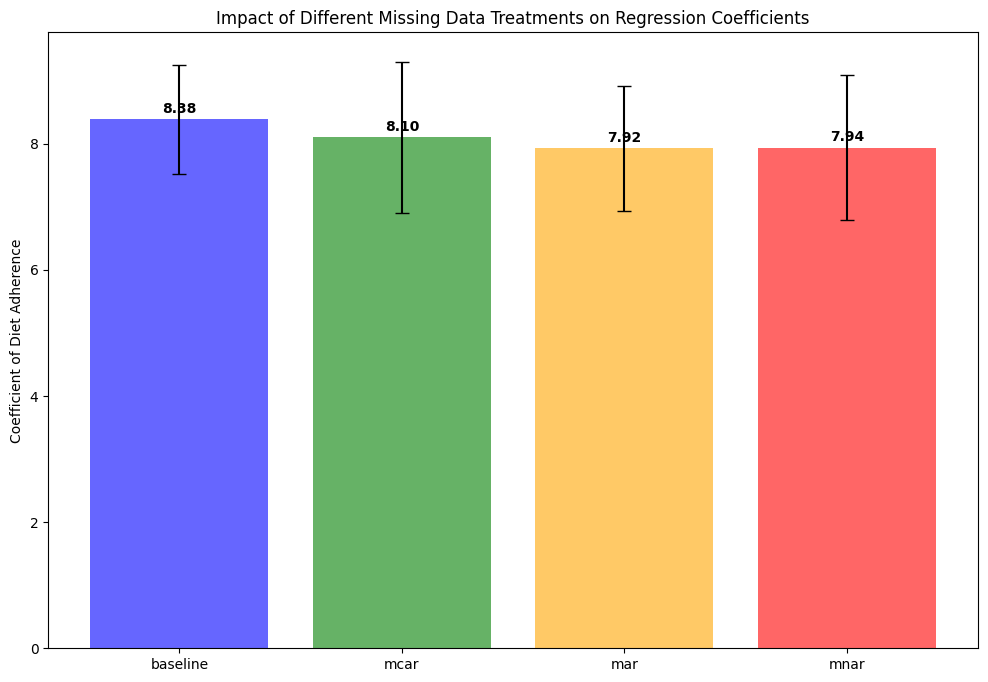

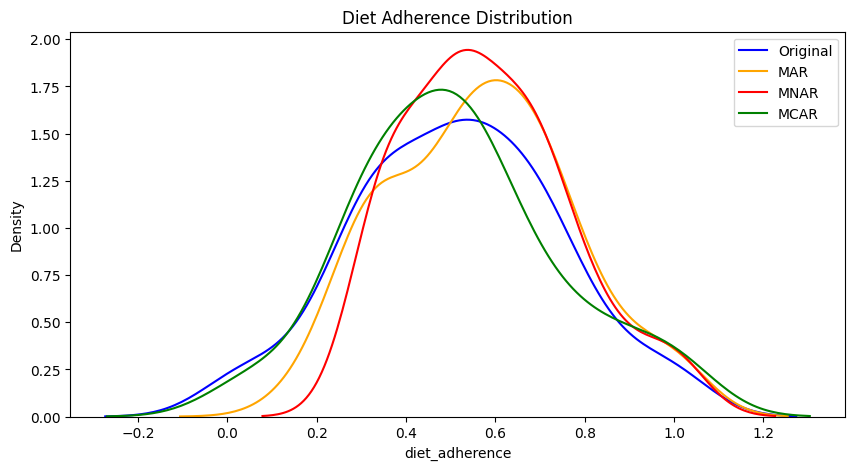

In [515]:
# Plotting the data
visualize_regression_results(results, 'Impact of Different Missing Data Treatments on Regression Coefficients')

visualize_distributions(data_full, data_mar, data_mnar, data_mcar,'Diet Adherence Distribution')


### Interpretation of models without imputation
#### MCAR
* For MCAR (Missing completely at random) we removed 40% of the data from the diet_adherence column ramdomly. 
* In comparison to the baseline model without missing data we can see that the missing data leads to overestmating the importance of adhering to the diet by assigning it a higher coefficient. We can also observe that the confidence intervals width and the std_err increases.
#### MAR
* For MAR (Missing at random) we removed 80% of the data from the diet_adherence column for people who are heavier than 85kg. 
* In comparison to the baseline model without missing data we can see that the missing data leads to overestmating the importance of adhering to the diet by assigning it a higher coefficient. We can also observe that the confidence intervals width and the std_err stays roughly the same.
#### MNAR
* For MNAR (Missing not at random) we removed all data from the diet_adherence column if the adherence to the diet was lower than 30%. 
* In comparison to the baseline model without missing data we can see that the missing data leads to underestimating the importance of adhering to the diet by assigning it a lower coefficient. We can also observe that the confidence intervals width and the std_err increases quite significantly.


### Simple imputation
We were able to observe that missing data effects the quality of our results. We can fight this by imputing data, which means filling non existent data points with data. 
An easy way to do this is by using Simple Imputation - In this case we will fill missing values with the mean/median value of the column.  

In [474]:
# Imputing missing data using Simple Imputation
data_mcar_imputed = data_mcar.copy()
data_mar_imputed = data_mar.copy()
data_mnar_imputed = data_mnar.copy()

# Simple imputation using mean
mean_imputer = SimpleImputer(strategy='mean')
data_mcar_imputed['diet_adherence'] = mean_imputer.fit_transform(data_mcar_imputed[['diet_adherence']]) 
data_mar_imputed['diet_adherence'] = mean_imputer.fit_transform(data_mar_imputed[['diet_adherence']])
data_mnar_imputed['diet_adherence'] = mean_imputer.fit_transform(data_mnar_imputed[['diet_adherence']])

print(data_mcar_imputed.isnull().sum(), '\n')
print(data_mar_imputed.isnull().sum(), '\n')
print(data_mnar_imputed.isnull().sum(), '\n')


initial_weight    0
age               0
diet_adherence    0
weight_loss       0
dtype: int64 

initial_weight    0
age               0
diet_adherence    0
weight_loss       0
dtype: int64 

initial_weight    0
age               0
diet_adherence    0
weight_loss       0
dtype: int64 



In [475]:
# Running regression on imputed data
mcar_imputed_model = linear_regression(data_mcar_imputed)
mar_imputed_model = linear_regression(data_mar_imputed)
mnar_imputed_model = linear_regression(data_mnar_imputed)

results_imputed = pd.DataFrame({
    'baseline': baseline_model,
    'mcar': mcar_imputed_model,
    'mar': mar_imputed_model,
    'mnar': mnar_imputed_model,
})

results_imputed

,baseline,mcar,mar,mnar
coef,8.384603,8.098281,7.924974,7.937957
std_err,0.438688,0.921366,0.880479,1.042866
ci_lower,7.514041,6.269861,6.177693,5.868423
ci_upper,9.255165,9.926702,9.672255,10.007492


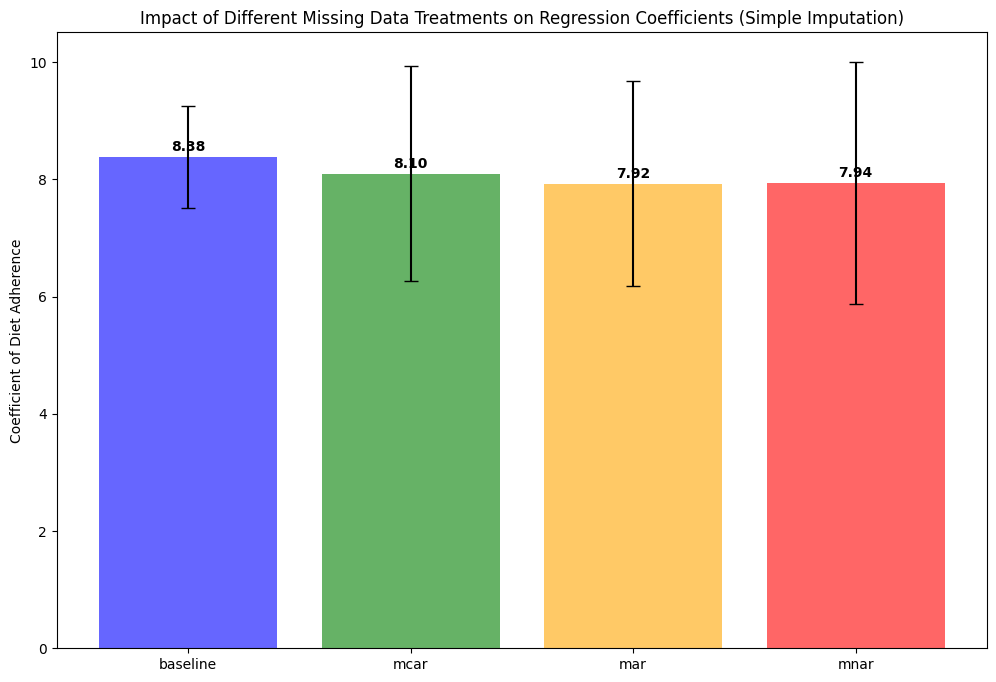

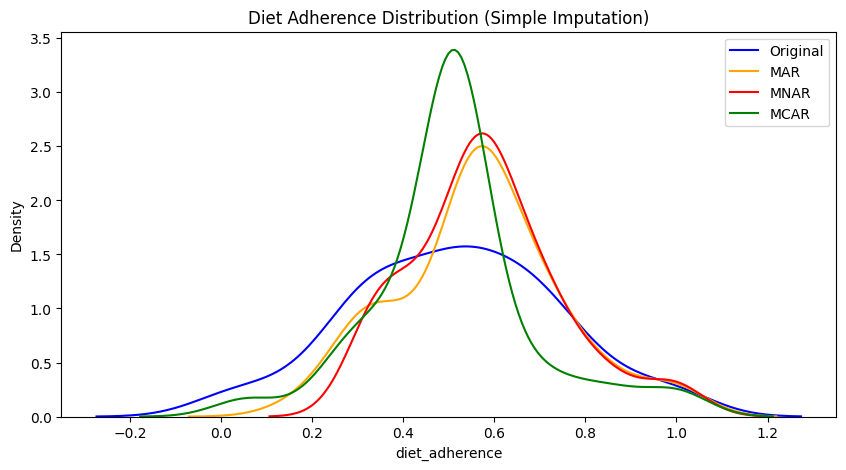

In [516]:
visualize_regression_results(results_imputed, 'Impact of Different Missing Data Treatments on Regression Coefficients (Simple Imputation)')

visualize_distributions(data_full, data_mar_imputed, data_mnar_imputed, data_mcar_imputed, 'Diet Adherence Distribution (Simple Imputation)')

### Simple Imputation Interpretation
We can see some minor changes after performing simple imputation. The std_err has become worse for all three cases, this could be an indication that we have introduced some bias into the data. We have also widened that gap for the confidence intervals. 

### Multiple Imputation using DAGs
Another way to perform imputation is multiple imputation using DAGs. This is a causal way of data imputation, which we hope will help us to impute missing data without introducing additional bias to the dataset. 

#### Steps:
1. Establish an visualize DAG: We need to determine the realtionships among the variables. For visualization we will use networkx
2. Multiple Imputation: We will use statsmodels to handle multiple imputation. We will implement a MICE (Multiple Imputation by Chained Equations) model, where we need to ensure that the order of imputation respects the causal dirctions found in our DAG.

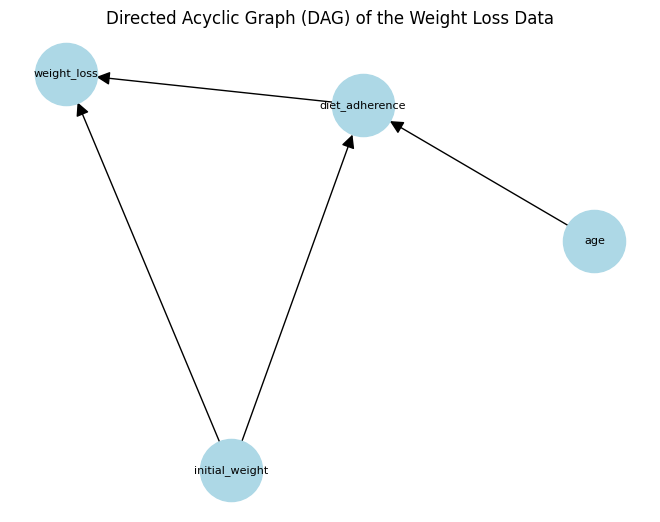

In [477]:
# Define DAG (These are assumptions that we are making about the data and the relationships between variables)
dag = nx.DiGraph()
dag.add_edge('initial_weight', 'diet_adherence')
dag.add_edge('age', 'diet_adherence')
dag.add_edge('diet_adherence', 'weight_loss')
dag.add_edge('initial_weight', 'weight_loss')

# Visualize the DAG 
pos = nx.layout.spring_layout(dag)
nx.draw(dag, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=8, arrowsize=20)
plt.title('Directed Acyclic Graph (DAG) of the Weight Loss Data')
plt.show()

In [478]:
iterative_imputer = IterativeImputer(max_iter=10, random_state=73)

def iterative_imputation(data):
    imputed_values = iterative_imputer.fit_transform(data[['initial_weight', 'age', 'diet_adherence']])
    data[['initial_weight', 'age', 'diet_adherence']] = imputed_values
    return data

In [479]:
data_mcar_iterative = data_mcar.copy()
data_mar_iterative = data_mar.copy()
data_mnar_iterative = data_mnar.copy()

mcar_iterative_results = iterative_imputation(data_mcar_iterative)
mar_iterative_results = iterative_imputation(data_mar_iterative)
mnar_iterative_results = iterative_imputation(data_mnar_iterative)

In [480]:
mcar_iterative_model = linear_regression(mcar_iterative_results)
mar_iterative_model = linear_regression(mar_iterative_results)
mnar_iterative_model = linear_regression(mnar_iterative_results)

results_iterative = pd.DataFrame({
    'baseline': baseline_model,
    'mcar': mcar_iterative_model,
    'mar': mar_iterative_model,
    'mnar': mnar_iterative_model,
})

results_iterative

,baseline,mcar,mar,mnar
coef,8.384603,8.311994,8.269860,8.315916
std_err,0.438688,0.435654,0.435231,0.435969
ci_lower,7.514041,7.447452,7.406158,7.450750
ci_upper,9.255165,9.176536,9.133562,9.181081


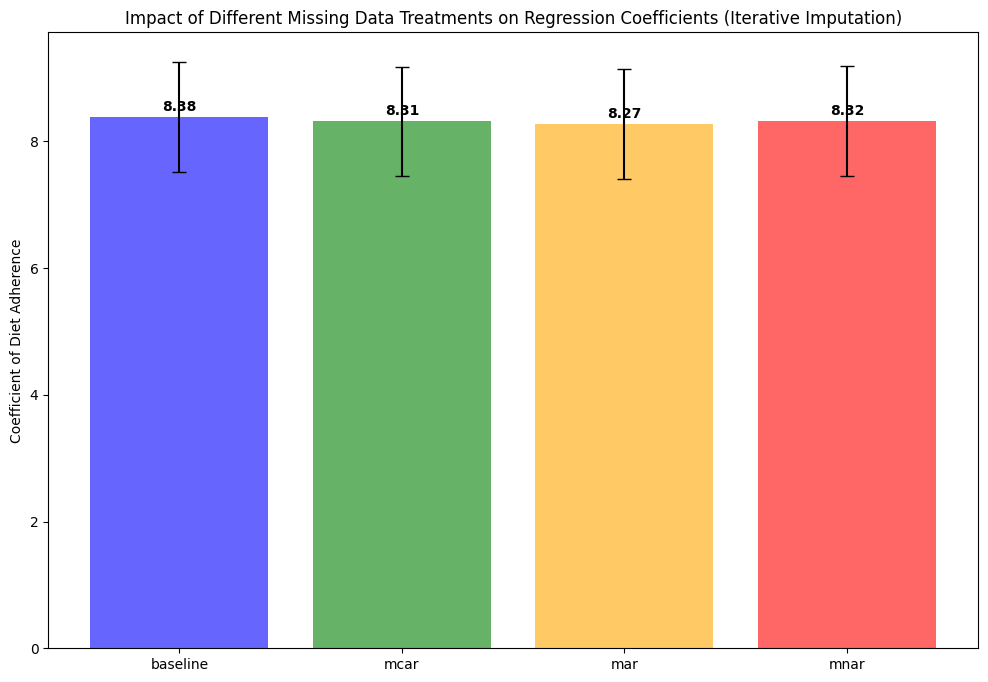

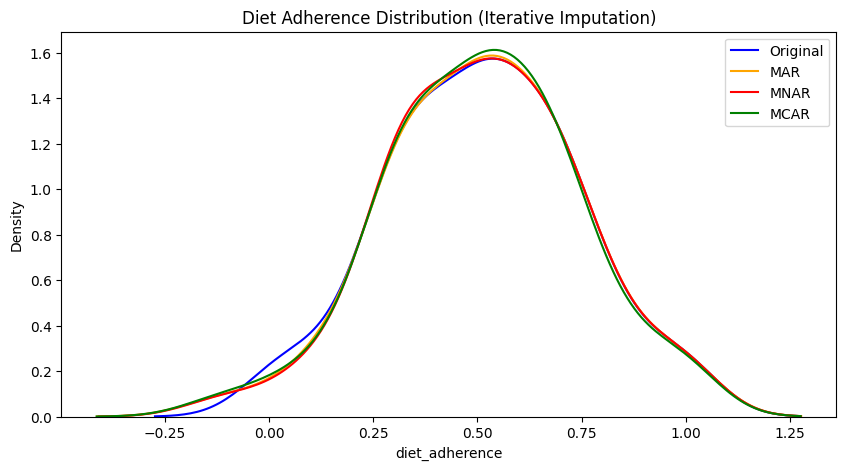

In [517]:
visualize_regression_results(results_iterative, 'Impact of Different Missing Data Treatments on Regression Coefficients (Iterative Imputation)')
visualize_distributions(data_full, data_mar_iterative, data_mnar_iterative, data_mcar_iterative, 'Diet Adherence Distribution (Iterative Imputation)')


In [482]:
# Causal Imputation
def causal_imputation(data, dependent_var, independent_vars):
    X = data[independent_vars]
    X = sm.add_constant(X)
    y = data[dependent_var]

    model = sm.OLS(y, X, missing='drop').fit()

    missing_indicies = data[dependent_var].isna()
    data.loc[missing_indicies, dependent_var] = model.predict(X[missing_indicies])

    return data

In [483]:
data_mcar_causal = data_mcar.copy()
data_mar_causal = data_mar.copy()
data_mnar_causal = data_mnar.copy()

mcar_causal_results = causal_imputation(data_mcar_causal, 'diet_adherence', ['age', 'initial_weight'])
mar_causal_results = causal_imputation(data_mar_causal, 'diet_adherence', ['age', 'initial_weight'])
mnar_causal_results = causal_imputation(data_mnar_causal, 'diet_adherence',['age', 'initial_weight'])

results_causal = pd.DataFrame({
    'baseline': baseline_model,
    'mcar': linear_regression(mcar_causal_results),
    'mar': linear_regression(mar_causal_results),
    'mnar': linear_regression(mnar_causal_results),
})

results_causal

,baseline,mcar,mar,mnar
coef,8.384603,8.311359,8.269442,8.315291
std_err,0.438688,0.435619,0.435199,0.435928
ci_lower,7.514041,7.446888,7.405804,7.450206
ci_upper,9.255165,9.175831,9.133081,9.180377


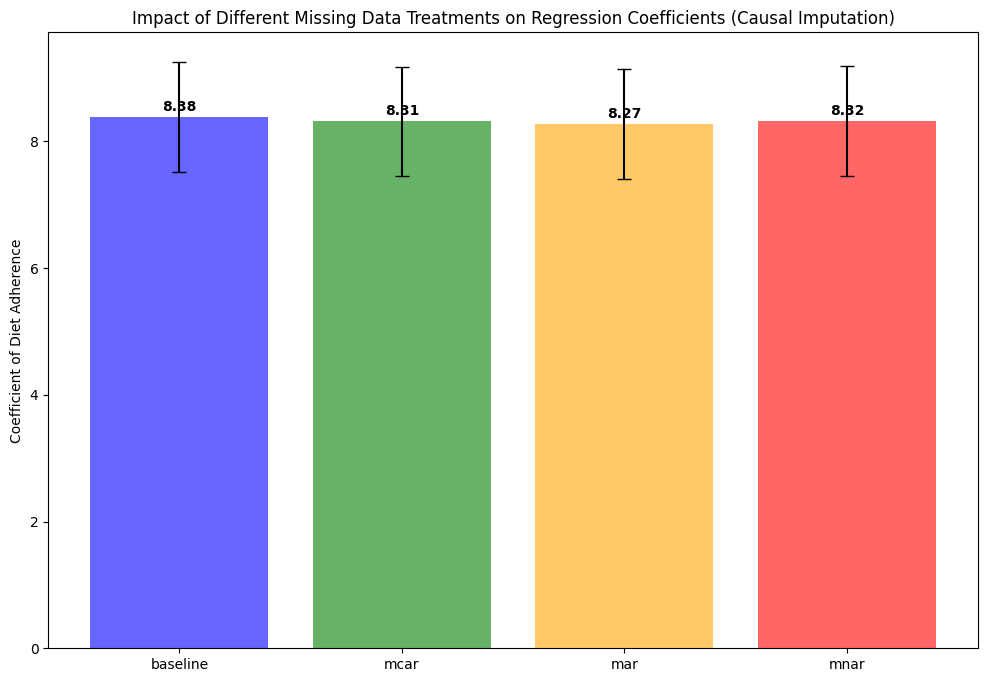

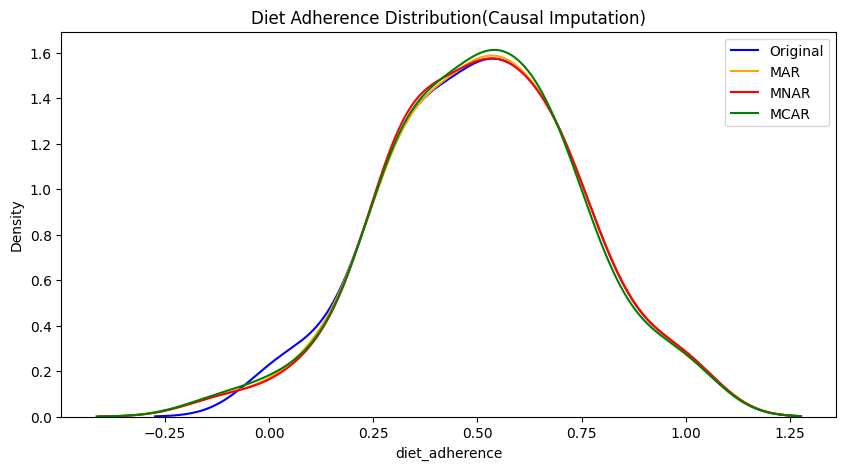

In [518]:
visualize_regression_results(results_causal, 'Impact of Different Missing Data Treatments on Regression Coefficients (Causal Imputation)')

visualize_distributions(data_full, data_mar_causal, data_mnar_causal, data_mcar_causal, 'Diet Adherence Distribution(Causal Imputation)')

In [487]:
def mice_imputation(data, predictors, num_iterations):
    imputer = mice.MICEData(data)
    imputer.set_imputer('diet_adherence', formula=predictors)
    for i in range(num_iterations):
        imputer.update_all()
    return imputer.data

In [501]:
data_mcar_mice = data_mcar.copy()
data_mar_mice = data_mar.copy()
data_mnar_mice = data_mnar.copy()

mcar_mice_results = mice_imputation(data_mcar_mice, 'age + initial_weight', 40)
mar_mice_results = mice_imputation(data_mar_mice, 'age + initial_weight', 25)
mnar_mice_results = mice_imputation(data_mnar_mice, 'age + initial_weight', 35)

mcar_mice_model = linear_regression(mcar_mice_results)
mar_mice_model = linear_regression(mar_mice_results)
mnar_mice_model = linear_regression(mnar_mice_results)

results_mice = pd.DataFrame({
    'baseline': baseline_model,
    'mcar': mcar_mice_model,
    'mar': mar_mice_model,
    'mnar': mnar_mice_model,
})

results_mice

,baseline,mcar,mar,mnar
coef,8.384603,8.032029,8.871905,9.447496
std_err,0.438688,0.597881,0.618548,0.669190
ci_lower,7.514041,6.845554,7.644417,8.119510
ci_upper,9.255165,9.218503,10.099393,10.775482


In [522]:
def visualize_regression_results_side_by_side(results1, title1, results2, title2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8), sharey=True)

    def plot_results(ax, results, title):
        scenarios = results.columns
        colors = ['blue', 'green', 'orange', 'red']
        coefficients = results.loc['coef', :]
        ci_bounds = [(results.loc['ci_lower', scenario], results.loc['ci_upper', scenario]) for scenario in scenarios]
        ci_lower = [coef - ci[0] for coef, ci in zip(coefficients, ci_bounds)]
        ci_upper = [ci[1] - coef for coef, ci in zip(coefficients, ci_bounds)]
        
        ax.bar(scenarios, coefficients, yerr=[ci_lower, ci_upper], capsize=5, color=colors, alpha=0.6)
        ax.set_ylabel('Coefficient of Diet Adherence')
        ax.set_title(title)
        ax.set_xticks(range(len(scenarios)))
        ax.set_xticklabels(scenarios)
        for i, coef in enumerate(coefficients):
            ax.text(i, coef + 0.1, f'{coef:.2f}', ha='center', color='black', fontweight='bold')

    plot_results(axes[0], results1, title1)
    plot_results(axes[1], results2, title2)

    plt.tight_layout()
    plt.show()

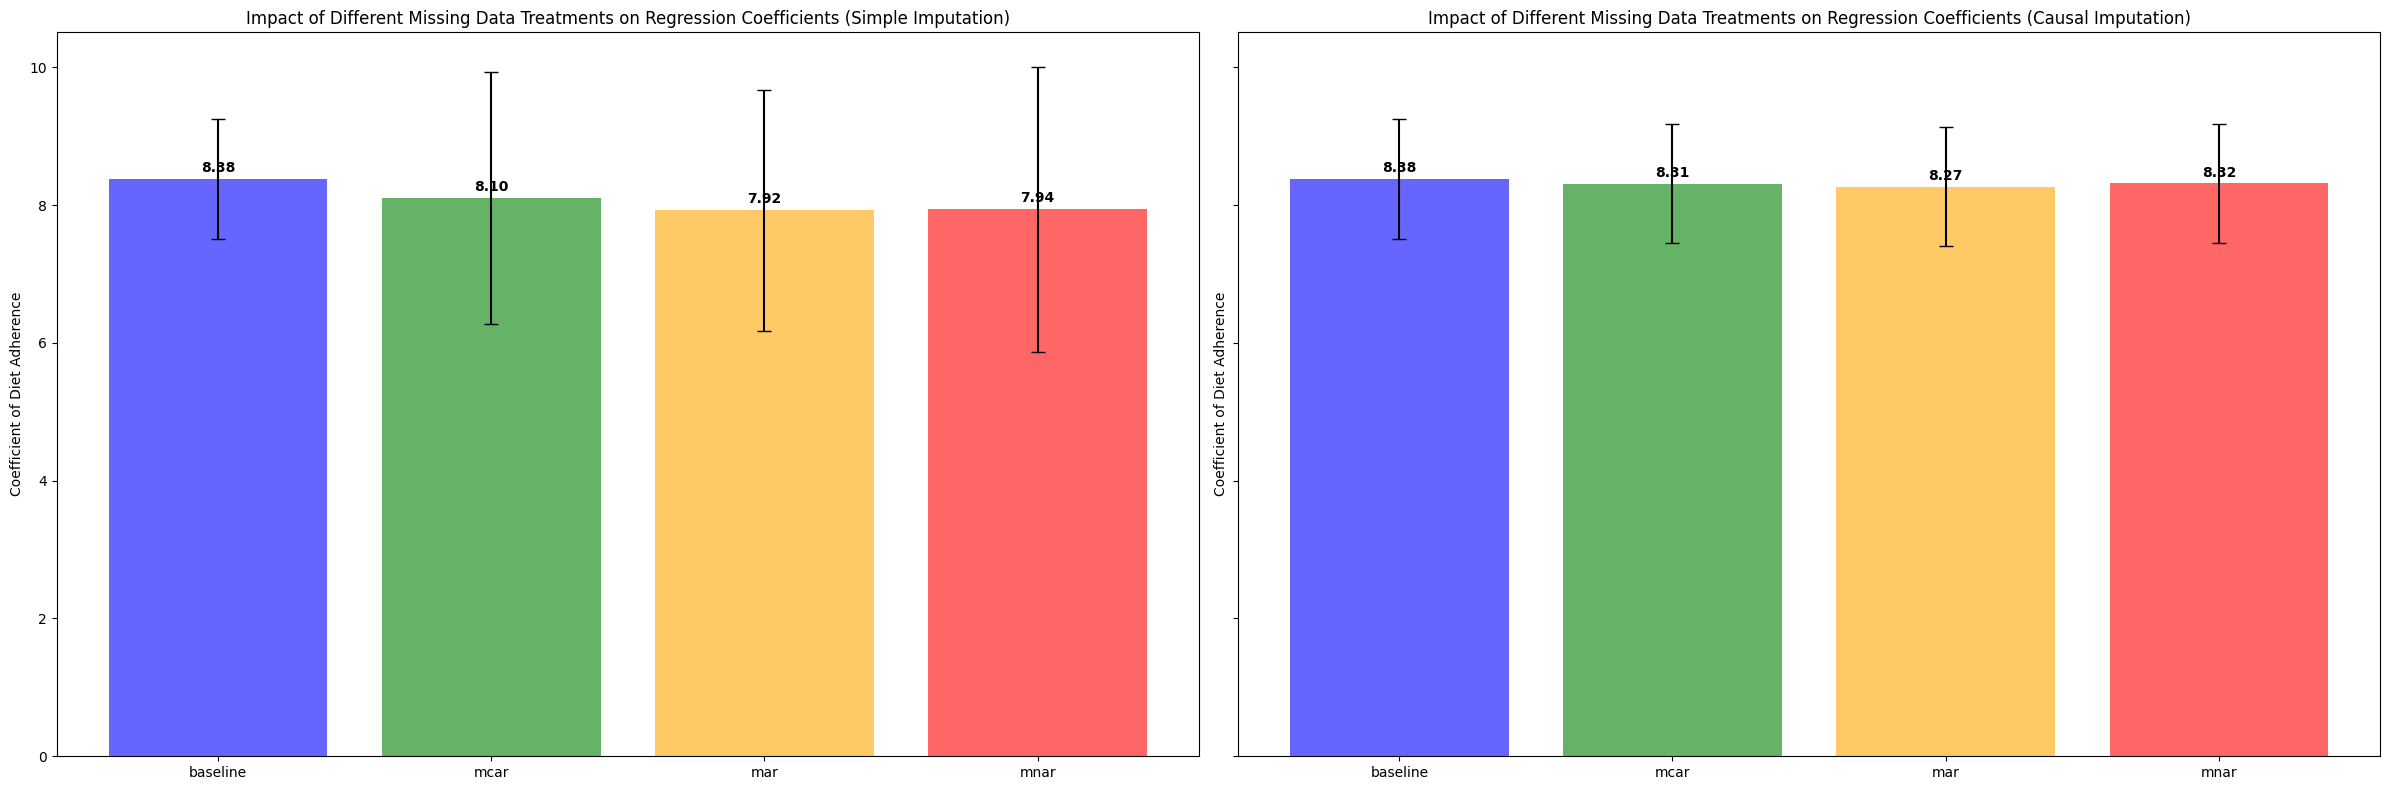

In [523]:
visualize_regression_results_side_by_side(
    results_imputed, 
    'Impact of Different Missing Data Treatments on Regression Coefficients (Simple Imputation)',
    results_causal,
    'Impact of Different Missing Data Treatments on Regression Coefficients (Causal Imputation)'
)

In [525]:
def visualize_distributions_side_by_side(original, simple_mar, simple_mnar, simple_mcar, causal_mar, causal_mnar, causal_mcar):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
    
    def plot_distributions(ax, original, imputed_mar, imputed_mnar, imputed_mcar, title):
        sns.kdeplot(original['diet_adherence'].dropna(), label='Original', color='blue', ax=ax)
        sns.kdeplot(imputed_mar['diet_adherence'].dropna(), label='MAR', color='orange', ax=ax)
        sns.kdeplot(imputed_mnar['diet_adherence'].dropna(), label='MNAR', color='red', ax=ax)
        sns.kdeplot(imputed_mcar['diet_adherence'].dropna(), label='MCAR', color='green', ax=ax)
        ax.set_title(title)
        ax.legend()

    plot_distributions(axes[0], original, simple_mar, simple_mnar, simple_mcar, 'Distributions after Simple Imputation')
    plot_distributions(axes[1], original, causal_mar, causal_mnar, causal_mcar, 'Distributions after Causal Imputation')

    plt.tight_layout()
    plt.show()

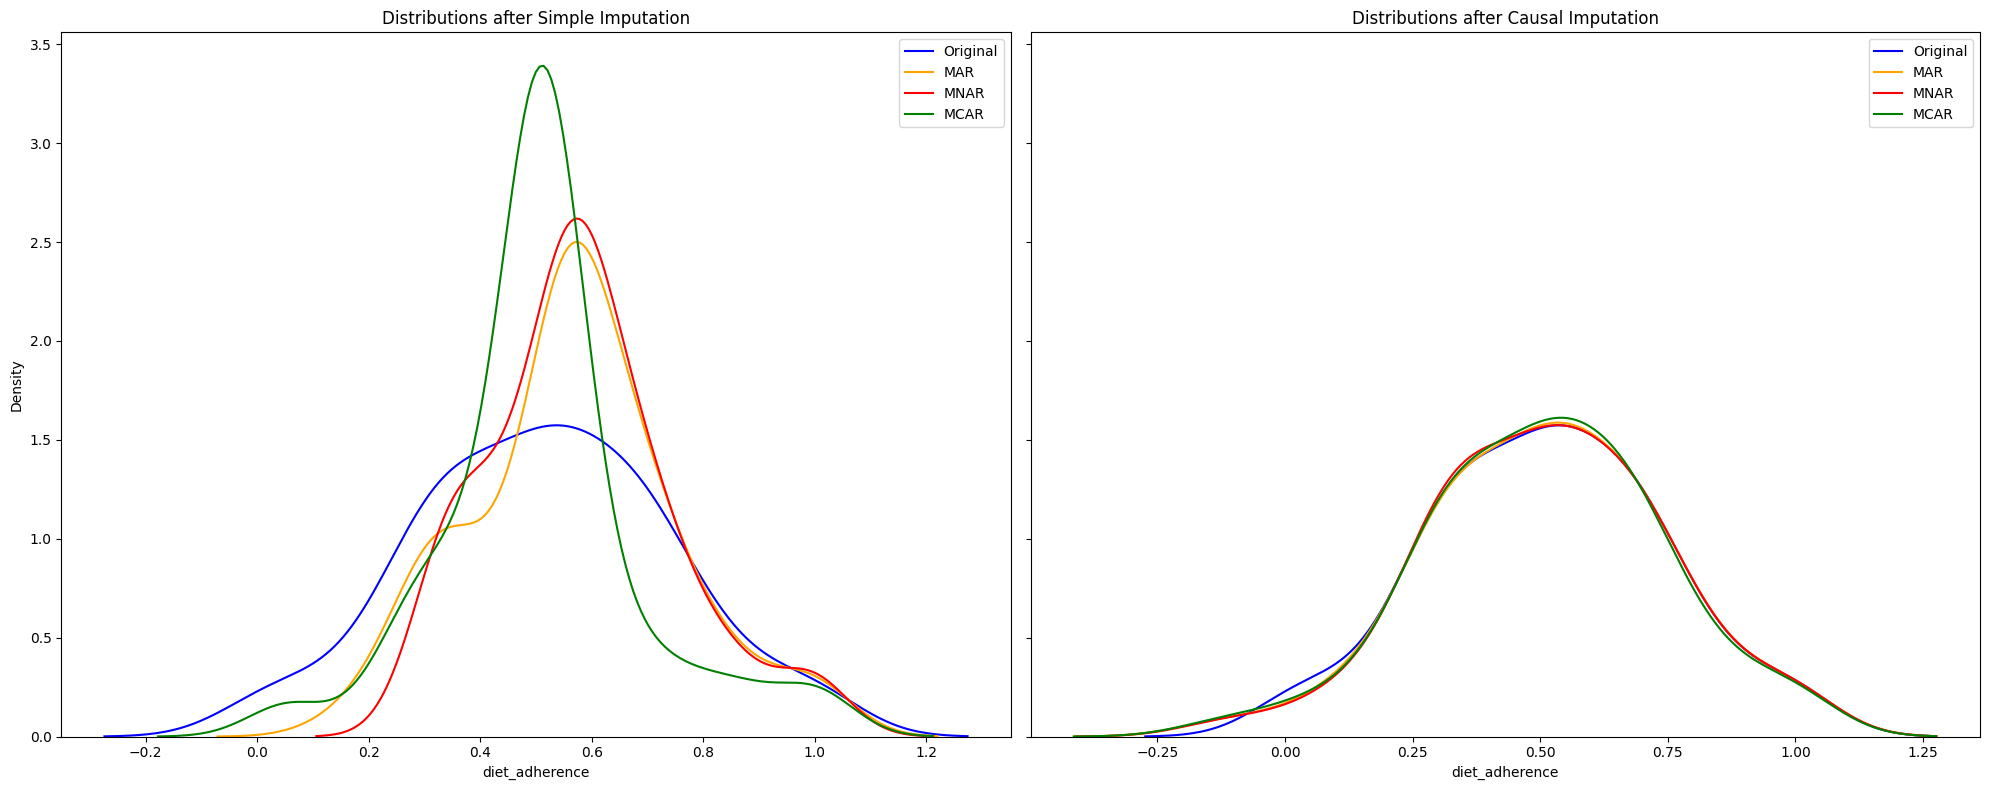

In [526]:
# Visualizing the distributions side by side
visualize_distributions_side_by_side(
    data_full, 
    data_mar_imputed, 
    data_mnar_imputed, 
    data_mcar_imputed,
    data_mar_causal,
    data_mnar_causal,
    data_mcar_causal
)

In [527]:
# Missing Data
data_mcar_missing = data_mcar.copy()
data_mar_missing = data_mar.copy()
data_mnar_missing = data_mnar.copy()

# Dropping missing values
data_mcar_missing = data_mcar_missing.dropna()
data_mar_missing = data_mar_missing.dropna()
data_mnar_missing = data_mnar_missing.dropna()

# Running regression on data with missing values dropped
mcar_missing_model = linear_regression(data_mcar_missing)
mar_missing_model = linear_regression(data_mar_missing)
mnar_missing_model = linear_regression(data_mnar_missing)

results_missing = pd.DataFrame({
    'baseline': baseline_model,
    'mcar': mcar_missing_model,
    'mar': mar_missing_model,
    'mnar': mnar_missing_model,
})

results_missing

,baseline,mcar,mar,mnar
coef,8.384603,8.098281,7.924974,7.937957
std_err,0.438688,0.601059,0.494615,0.578611
ci_lower,7.514041,6.895132,6.940468,6.786703
ci_upper,9.255165,9.301431,8.909480,9.089212


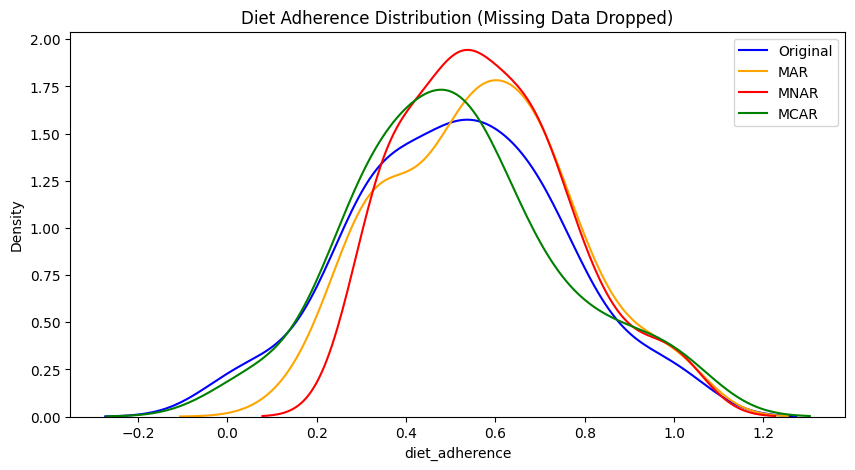

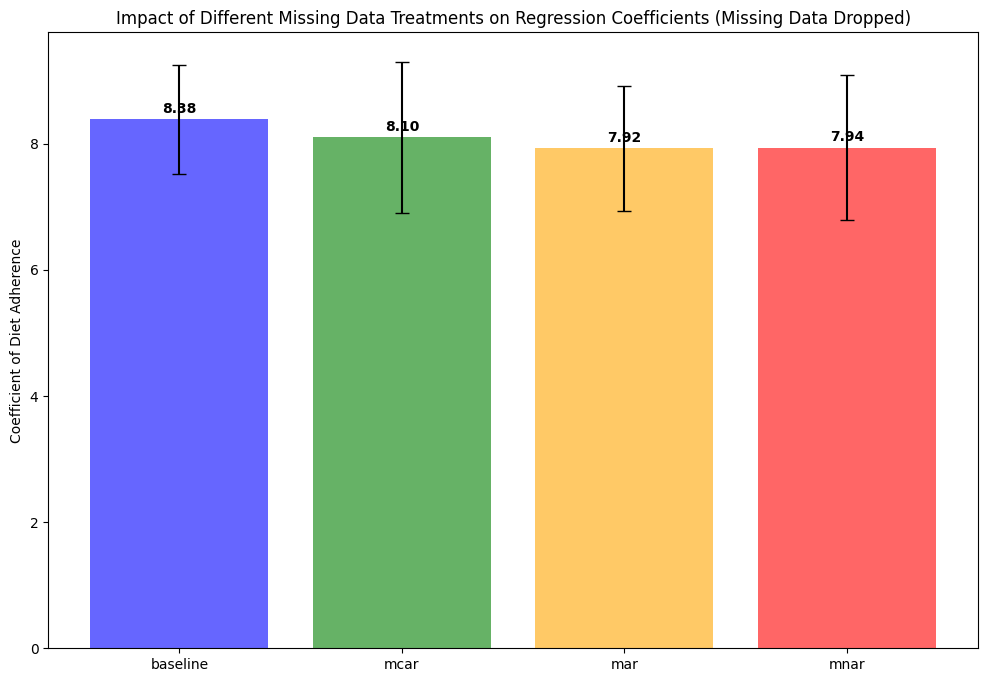

In [528]:
visualize_distributions(data_full, data_mar_missing, data_mnar_missing, data_mcar_missing, 'Diet Adherence Distribution (Missing Data Dropped)')
visualize_regression_results(results_missing, 'Impact of Different Missing Data Treatments on Regression Coefficients (Missing Data Dropped)')

### Multiple Imputation Interpretation
We can observe that multiple imputation can have it's advantages if you know the data well. In this case we have created the data and therefore know how the data is created and why some data is missing. For MCAR we were able to implement a great imputation and almost retain the same values as the baseline model. In case of mar we also performed better than the simple or no imputation cases, by simply applying general knowledge we had about the data. However, in the case of mnar we (simulated) having know further knowledge about the, other from what we were able to get from the DAG. In mnar we reached the wrong conclusion, by not adjusting for the data not being missing at random. If we were to provide a better formula we could obtain much better results. 

## Paper Sketch
### 1. Understanding the Impact of Missing Data
#### Nature of Missing Data:
* MCAR (Missing Completely at Random): The likelihood of missing data is independent of both observed and unobserved data.
* MAR (Missing at Random): The likelihood of missing data depends only on the observed data.
* MNAR (Missing Not at Random): The likelihood of missing data depends on the values of the data itself, whether observed or not.
#### Challenges:
* Missing data can lead to biased statistical inferences, reduced statistical power, and can ultimately affect the validity and generalizability of study conclusions. For example, MAR and MNAR scenarios require sophisticated statistical techniques to prevent biased results, as standard imputation methods assuming MCAR can be misleading.
### 2. Implications of Missing Data in Causal Analysis:
#### Bias from Missing Data:
* Missingness, especially if MNAR, can introduce significant bias in estimating causal effects. For instance, if lower diet adherence (a key variable in a study) systematically goes unreported, analyses that do not correct for this are likely to overestimate the effectiveness of a dietary intervention.
### 3. Imputation Techniques and Causal Structure:
#### Comparison of Techniques:
* Traditional imputation techniques often assume MCAR or at best MAR, using methods like mean substitution or regression imputation. In contrast, causal imputation methods like MICE incorporate additional structural information from DAGs, which can more accurately model the dependencies among variables and hence maintain the integrity of causal inferences.
### 4. Causal Approach to Handle Missing Data:
#### Application of DAGs:
* DAGs help in specifying the conditional dependencies and causal structure among variables, which is crucial for correctly specifying the imputation model in methods like MICE.
#### Methodology:
* Multiple imputation using DAGs involves setting up a sequence of regression models that reflect the conditional dependencies dictated by the DAG, ensuring that each variable's imputation is informed by its causally prior variables.
### 5. Justification and Importance of the Causal Approach
#### Advantages:
* Reduces bias in estimates, particularly in MAR and MNAR scenarios, by leveraging known causal relationships to more accurately predict missing values.
* Preserves relationships among variables by respecting the causal pathways, enhancing the credibility and robustness of causal inferences from the data.
#### Limitations:
* Complexity and computational intensity increase as the causal models and the number of variables grow.
* Requires substantial knowledge of the subject matter to correctly specify the DAG and the imputation models, which may not always be feasible.